In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.drop_duplicates(inplace=True)
df.isna().sum().sum()==0
#чистим данные

True

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Что говорят авторы датасета:
* В датасете история транзакций за два дня, 492 мошеннических транзакций из 284,807.
* V1-V28 - числовые значения, прошедшие PCA-преобразования, что они значат - неизвестно.
* Time - время между i-й и первой транзакциями. Amount - сумма транзакции, Class - целевая переменная(1 - мошенническая транзакция, 0 - нет)
* Датасет очень несбалансированный, так что для измерения точности рекомендуется использовать AUPRC.

In [5]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

In [6]:
df.describe()
#посмотрим основные статистики фич

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


D:\1s\Anaconda3\envs\new\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

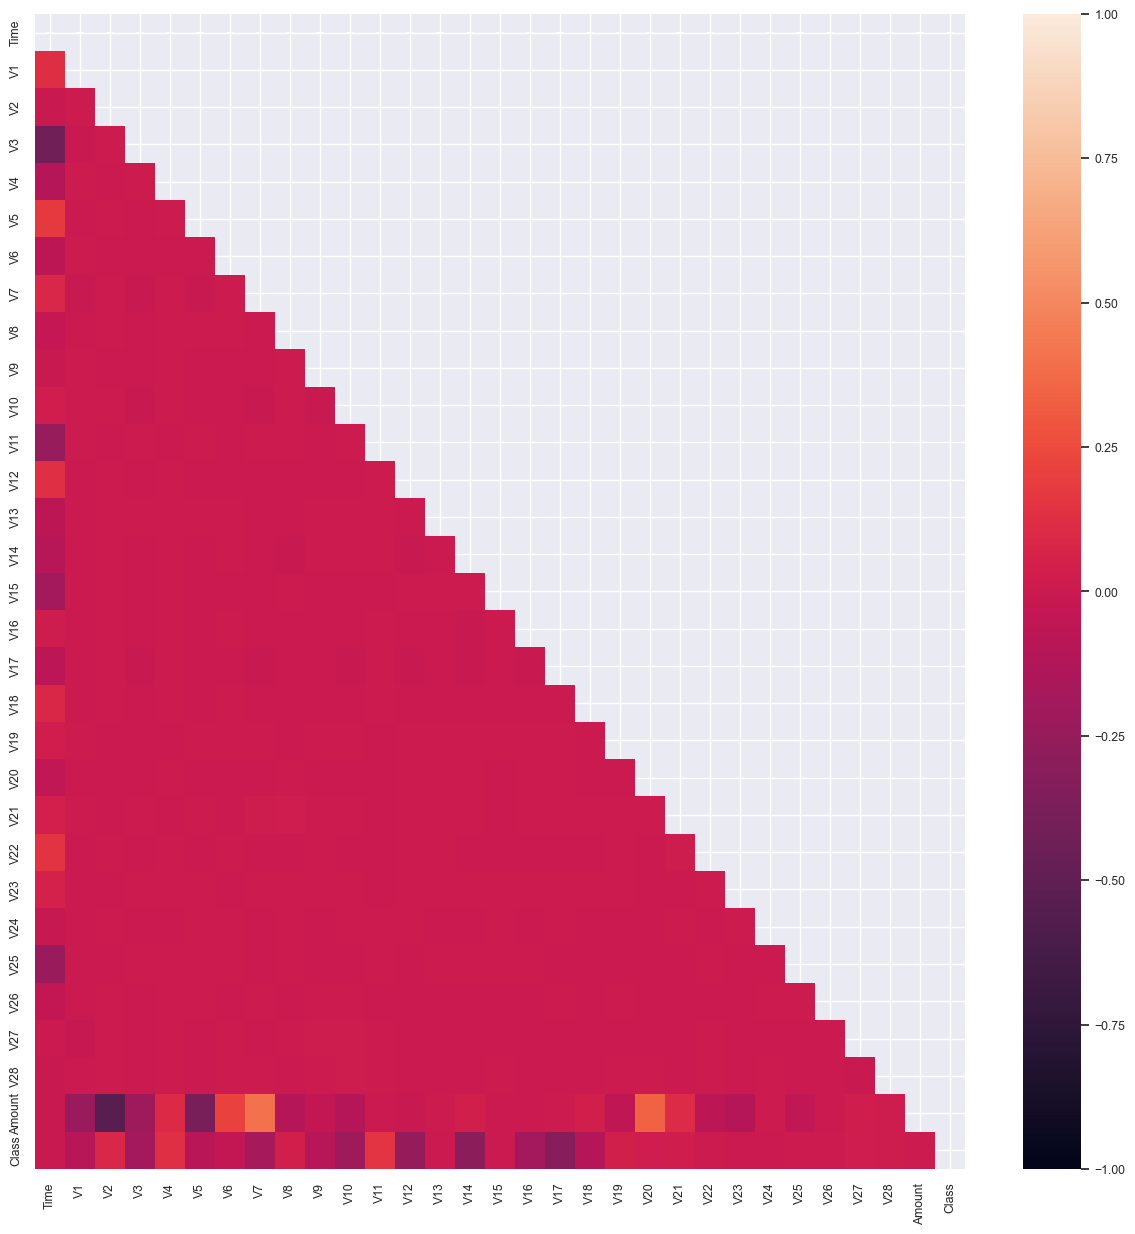

In [7]:
plt.figure(figsize=(15,15))
sns.set(font_scale=0.8)
sns.heatmap(
    df.corr(),
    annot=True,
    vmin=-1, 
    vmax=1,
    fmt ='.3f',
    mask=np.triu(df.corr()),
)
#построим матрицу корреляции между фичами

Между собой фичи особо не коррелируют. На целевую Class влияют V1-V28, в особенности до V18.\
Time измеряется в секундах, поэтому имеет большие разброс и среднее. В дальнейшем можно его отбросить.

In [22]:
cols = ['V1', 'V2', 'V3', 'Class']
sns_plot = sns.pairplot(df[cols], hue='Class')
#исследуем попарные зависимости фич

D:\1s\Anaconda3\envs\new\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\1s\Anaconda3\envs\new\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\1s\Anaconda3\envs\new\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

KeyboardInterrupt



Error in callback <function flush_figures at 0x0000026000063040> (for post_execute):


KeyboardInterrupt: 

Зависимость во многих случаях нелинейная, поэтому будем использовать нелинейные модели KNN, Random Forest, HGBoost.

In [8]:
X = df.drop(labels=['Class','Time', 'Amount'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
#разбиваем данные на обучающую и тестовую подвыборки

In [9]:
y_train.value_counts()[1]/y_train.value_counts()[0] - y_test.value_counts()[1]/y_test.value_counts()[0]
#смотрим, равно ли соотношение числа элементов двух классов в обучающей и тестовой выборке

4.730765120787139e-06

Имеем несбалансированный датасет, на котором алгоритм может просто не обучится. Одно из решений - оверсемплинг, добавление новых экземпляров меньшего по размеру класса. Применим RandomOverSampling и SMOTE из imblearn.

In [13]:
samplers = [
    ("ROS", RandomOverSampler(random_state=17)), 
    ("SMOTE", SMOTE(random_state=17))
]
classifiers = [
    ("KNN", KNeighborsClassifier(n_jobs=-1, n_neighbors=3)),
    ("RandomForest", RandomForestClassifier(n_jobs=-1, random_state=17)),
    ("HGBoost", HistGradientBoostingClassifier(random_state=17))
]

In [16]:
models = []
scaler = StandardScaler()
for sampler in samplers:
    for clf in classifiers:
        name =  f"{sampler[0]} {clf[0]}"
        print(name)
        model = make_pipeline(scaler, sampler[1], clf[1])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_true=y_test, y_pred=y_pred)
        models.append((
                name,
                report,
                model
            ))
        print(report)

ROS KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.73      0.76      0.74       118

    accuracy                           1.00     70932
   macro avg       0.86      0.88      0.87     70932
weighted avg       1.00      1.00      1.00     70932

ROS RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.94      0.74      0.82       118

    accuracy                           1.00     70932
   macro avg       0.97      0.87      0.91     70932
weighted avg       1.00      1.00      1.00     70932

ROS HGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.85      0.78      0.81       118

    accuracy                           1.00     70932
   macro avg       0.93      0.89      0.91     70932
weighted avg       1.00      1.00    

Для данной задачи лучше ориентироваться на f1-score, поэтому лучше всего подходят ROS RandomForest, ROS HGBoost и SMOTE RandomForest. Выберем первый.

In [17]:
models[1]

('ROS RandomForest',
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     70814\n           1       0.94      0.74      0.82       118\n\n    accuracy                           1.00     70932\n   macro avg       0.97      0.87      0.91     70932\nweighted avg       1.00      1.00      1.00     70932\n',
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomoversampler', RandomOverSampler(random_state=17)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_jobs=-1, random_state=17))]))

In [18]:
params = {
    "randomforestclassifier__n_estimators": (75, 100, 125),
    "randomforestclassifier__max_depth": (7, 10, 13)
}

In [19]:
gcv = GridSearchCV(estimator=models[1][2], param_grid=params, refit='recall', n_jobs=-1, cv=StratifiedKFold(n_splits=3))

In [20]:
gcv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=17)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=17))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': (7, 10, 13),
                         'randomforestclassifier__n_estimators': (75, 100,
                                                                  125)},
             refit='recall')

In [21]:
gcv.best_params_

{'randomforestclassifier__max_depth': 13,
 'randomforestclassifier__n_estimators': 100}

In [22]:
clf = gcv.best_estimator_
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.84      1.00      0.91       118

    accuracy                           1.00     70932
   macro avg       0.92      1.00      0.96     70932
weighted avg       1.00      1.00      1.00     70932



Получили, что модель Random Forest + Random Over Sampler добилась на кроссвалидации recall=1.00 и precision=0.84, что является лучшим результатом.